In [1]:
using JLD2, FileIO
using Quaternions
using LinearAlgebra
using Statistics
using PyPlot
using ProgressMeter
include("QRPNN.jl");

┌ Info: Recompiling stale cache file /home/valle/.julia/compiled/v1.0/JLD2/O1EyT.ji for JLD2 [033835bb-8acc-5ee8-8aae-3f567f8a3819]
└ @ Base loading.jl:1190


In [2]:
N = 100;
K = 36;
tau = 1.e-4;

In [3]:
# Parameters;
L = 3.0;
alpha = 4.0;
q = 5.0;
it_max = 1.e+3

params=[nothing,alpha,L,q]
fs = [QRPNN.identity, QRPNN.exponential, QRPNN.potential, QRPNN.high_order];

In [4]:
pr = Array{Float64}(0.0:0.05:1.0)
Smax = 100

PrRecall = zeros(Int64,(10,length(pr)))

@showprogress for s = 1:Smax
    # Generate the fundamental memories
    U = Array{Quaternion{Float64}}(undef,(N,K))
    for i = 1:N
        for j = 1:K
            U[i,j] = Quaternion(2*round(rand(1)[1])-1,0,0,0)
        end
    end

    # Train the projection models
    Vs = []
    for j=1:4
        push!(Vs,QRPNN.train(fs[j],params[j],U))
    end
    
    # Projection
    Up = inv((U'*U)/N)*U'
    
    for i = 1:length(pr)
        x = copy(U[:,1]) .* (1 .- 2*(rand(N,1) .< pr[i]))
        
        #
        # Hopfield
        #
        y = QRPNN.hopfield(U/(4*N), U', x, it_max)
        PrRecall[1,i] = PrRecall[1,i]+(norm(U[:,1]-y)<tau)
        #
        y = QRPNN.hopfield(U/N, Up, x, it_max)
        PrRecall[2,i] = PrRecall[2,i]+(norm(U[:,1]-y)<tau)
        
        #
        # QRCNN
        #
        for j=1:4
            y = QRPNN.main(fs[j],params[j], U, U, x, it_max)
            PrRecall[2+j,i] = PrRecall[2+j,i]+(norm(U[:,1]-y)<tau)
        end
        
        #
        # QRPNN
        #
        for j=1:4
            y = QRPNN.main(fs[j],params[j], U, Vs[j], x, it_max)
            PrRecall[6+j,i] = PrRecall[6+j,i]+(norm(U[:,1]-y)<tau)
        end
    end
    @save "JLDs/Example1.jld2" pr PrRecall Smax
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


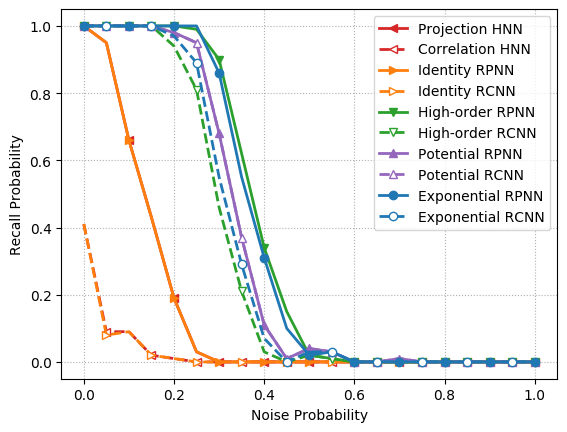

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [5]:
@load "JLDs/Example1.jld2"
plot(pr,PrRecall[2,:]/Smax,linewidth=2,color="#d62728",marker="<",markevery=(0,2),label="Projection HNN")
plot(pr,PrRecall[1,:]/Smax,linewidth=2,color="#d62728",marker="<",markevery=(1,2),mfc="white",linestyle="dashed",label="Correlation HNN")
plot(pr,PrRecall[7,:]/Smax,linewidth=2.0,color="#ff7f0e",marker=">",markevery=(0,2),label="Identity RPNN")
plot(pr,PrRecall[3,:]/Smax,linewidth=2,color="#ff7f0e",marker=">",markevery=(1,2),mfc="white",linestyle="dashed",label="Identity RCNN")
plot(pr,PrRecall[10,:]/Smax,linewidth=2,color="#2ca02c",marker="v",markevery=(0,2),label="High-order RPNN")
plot(pr,PrRecall[6,:]/Smax,linewidth=2,color="#2ca02c",marker="v",markevery=(1,2),mfc="white",linestyle="dashed",label="High-order RCNN")
plot(pr,PrRecall[9,:]/Smax,linewidth=2,color="#9467bd",marker="^",markevery=(0,2),label="Potential RPNN")
plot(pr,PrRecall[5,:]/Smax,linewidth=2,color="#9467bd",marker="^",markevery=(1,2),mfc="white",linestyle="dashed",label="Potential RCNN")
plot(pr,PrRecall[8,:]/Smax,linewidth=2,color="#1f77b4",marker="o",markevery=(0,2),label="Exponential RPNN")
plot(pr,PrRecall[4,:]/Smax,linewidth=2,color="#1f77b4",marker="o",markevery=(1,2),mfc="white",linestyle="dashed",label="Exponential RCNN")
grid(linestyle="dotted")
xlabel("Noise Probability")
ylabel("Recall Probability")
legend()
savefig("Figures/Example1.eps")
savefig("Figures/Example1.pdf")